In [7]:
import json
import emoji
import sys
import re
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [23]:
embedding_dim = 200
max_length = 120
filters = 64
kernel_size = 3
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [9]:
emoji_list = emoji.UNICODE_EMOJI.keys()


In [10]:
with open('racism.json', 'r') as file:
    data_racism = pd.read_json(file,lines=True)
with open('neither.json', 'r') as file:
    data_neither = pd.read_json(file,lines=True)
with open('sexism.json', 'r') as file:
    data_sexism = pd.read_json(file,lines=True)

In [11]:
labels_read = []
text_read = []
labels_read = list(data_racism['Annotation'])
text_read = list(data_racism['text'])
labels_read.extend(list(data_neither['Annotation']))
labels_read.extend(list(data_sexism['Annotation']))
text_read.extend(list(data_neither['text']))
text_read.extend(list(data_sexism['text']))

print(len(text_read))

16907


In [12]:
labels = list()
texts = list()
i = 0
for i in range(0,len(text_read)):
    labels.append(labels_read[i])
    texts.append(text_read[i])
print(type(text_read[i]))
print(len(texts))
print(len(labels))

<class 'str'>
16907
16907


In [13]:
FLAGS = re.MULTILINE | re.DOTALL

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"


def preprocess(text):
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)
    
    text = text.replace("#","<hashtag> ")
    
    no_emoji = ''
    for char in text:
        if char not in emoji_list:
            no_emoji = no_emoji + char
        else:
            no_emoji = no_emoji + '<' + emoji.demojize(char) + '> '
    text = no_emoji
    
    text = re_sub(r"@\w+","<user>")
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    text = re_sub(r"([A-Z]){2,}", allcaps)
    
    punctuations = '''!()-[]{};:'"\,./?@#$%^&*_~0123456789'''
    
    no_punct = ''
    for char in text:
        if char not in punctuations:
            no_punct = no_punct + char
    text = no_punct
    text = text.replace("  "," ")
    return text.lower()


In [14]:
for i in range(0, len(texts)):
    texts[i] = preprocess(texts[i])

In [15]:
print(preprocess('hello hello @arunima randi ki bachchi chutiya saali 😄😄'))

hello hello <user> randi ki bachchi chutiya saali <grinningfacewithsmilingeyes> <grinningfacewithsmilingeyes> 


In [16]:
print(texts[2213])

its gonna a girls round on <hashtag> mkr this week but idc bcuz its time for <hashtag> revenge amp lr <hashtag> sleepyhollow amp <hashtag> elementary <kissmark> <speechballoon> <facesavoringfood> <sparkles> <peoplewithbunnyears> <cooking> <television> <warning> ️


In [24]:
print(set(labels))

{'racism', 'none', 'sexism'}


In [17]:
train_tweets, validation_tweets, train_labels, validation_labels = train_test_split(texts, labels, test_size=0.2)
print(len(train_tweets))
print(len(train_labels))
print(len(validation_tweets))
print(len(validation_labels))
print(train_labels[:10])

13525
13525
3382
3382
['none', 'racism', 'racism', 'none', 'none', 'none', 'racism', 'sexism', 'none', 'none']


In [18]:
vocab_size=0
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_tweets)
word_index = tokenizer.word_index
vocab_size=len(word_index)

train_sequences = tokenizer.texts_to_sequences(train_tweets)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(word_index))
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

15065
19
120
19
120


In [19]:
validation_sequences = tokenizer.texts_to_sequences(validation_tweets)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

3382
(3382, 120)


In [20]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

padded_validation_label_seq = pad_sequences(validation_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)
train_lables_padded = pad_sequences(training_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)

category_word_index = label_tokenizer.word_index

In [21]:
print(train_padded.shape)
print(train_lables_padded.shape)

(13525, 120)
(13525, 1)


In [25]:
embeddings_index = {};
with open('glove.6B.200d.txt', errors='ignore') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])#, dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [26]:
def plot_graphs(history, string):

  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

Train on 13525 samples, validate on 3382 samples
Epoch 1/10
13525/13525 - 19s - loss: 0.5891 - acc: 0.7581 - val_loss: 0.4849 - val_acc: 0.8043
Epoch 2/10
13525/13525 - 15s - loss: 0.4545 - acc: 0.8108 - val_loss: 0.4546 - val_acc: 0.8087
Epoch 3/10
13525/13525 - 15s - loss: 0.4245 - acc: 0.8231 - val_loss: 0.4420 - val_acc: 0.8247
Epoch 4/10
13525/13525 - 15s - loss: 0.3979 - acc: 0.8384 - val_loss: 0.4281 - val_acc: 0.8261
Epoch 5/10
13525/13525 - 14s - loss: 0.3814 - acc: 0.8404 - val_loss: 0.4548 - val_acc: 0.8140
Epoch 6/10
13525/13525 - 12s - loss: 0.3586 - acc: 0.8521 - val_loss: 0.4423 - val_acc: 0.8258
Epoch 7/10
13525/13525 - 12s - loss: 0.3416 - acc: 0.8617 - val_loss: 0.4222 - val_acc: 0.8300
Epoch 8/10
13525/13525 - 12s - loss: 0.3227 - acc: 0.8682 - val_loss: 0.4291 - val_acc: 0.8321
Epoch 9/10
13525/13525 - 12s - loss: 0.3014 - acc: 0.8777 - val_loss: 0.4204 - val_acc: 0.8341
Epoch 10/10
13525/13525 - 12s - loss: 0.2889 - acc: 0.8827 - val_loss: 0.4312 - val_acc: 0.8294


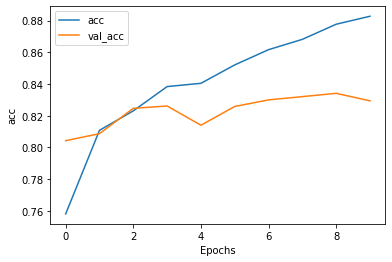

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length = max_length, weights=[embeddings_matrix], trainable=False),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation = 'sigmoid'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=0.005), metrics=['acc'])
# model.summary()
#adam(lr=.001>.0006)
num_epochs = 10
history = model.fit(train_padded, train_lables_padded, epochs = num_epochs, validation_data=(validation_padded, padded_validation_label_seq), verbose = 2)

plot_graphs(history, "acc")
plot_graphs(history, "loss")